In [ ]:
# import requireds
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# Import model librarys
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# Creating our Single Tron LSTM model
class LSTM_Prediction():

  # Define our variables
  def __init__(self , path):

    self.df = pd.read_csv(path, index_col = 'date' , parse_dates=True)
    self.df.drop(['year' , 'specefic_date' ,'total state_bottle_cost' , 'total state_bottle_retail' , 'total sale_dollars' , 'total volume_sold_liters'],axis = 1, inplace = True)
    self.X_train = self.df[:(len(self.df)-12)]
    self.X_test = self.df[(len(self.df)-12):]
    self.scaler = MinMaxScaler().fit(self.X_train)
    self.n_input = 12
    self.n_features = 1

  # Use the Min Max Scalling parameter
  def scale_data(self):
    self.scaled_train = self.scaler.transform(self.X_train)

  # Generate our Time Series
  def create_generator(self):

    self.scale_data()

    self.generator = TimeseriesGenerator(
                  self.scaled_train , 
                  self.scaled_train ,
                  length = self.n_input,
                  batch_size = self.n_features
            )
  
  # Creating of our lstm model
  def create_lstm_model(self):

    self.create_generator()

    self.model = Sequential()
    self.model.add(LSTM(100 , activation = 'relu',input_shape = (self.n_input , self.n_features)))
    self.model.add(Dense(1))
    self.model.compile(optimizer = 'adam',loss = 'mse',)
    self.model.fit(self.generator ,  epochs=50)

  # making future prediction
  def future_prediction(self):

    self.create_lstm_model()

    self.test_prediction = []
    first_data = self.scaled_train[-self.n_input:]
    current_data = first_data.reshape((1 , self.n_input , self.n_features))

    for i in range(12):

      current_pred = self.model.predict(current_data)[0]
      self.test_prediction.append(current_pred)
      current_data = np.append(current_data[: , 1: , :], [[current_pred]],axis = 1)
  
  # save our lstm model as h5
  def save_model(self):

      self.model.save('/content/LSTM_model.h5')  

  # make plot of our prediction
  def make_plot(self):

      self.future_prediction()

      Y_pred = self.scaler.inverse_transform(self.test_prediction)
      self.X_test['Prediction dollars'] = Y_pred
      self.X_test.plot(figsize = (12 , 6))

Epoch 1/50
54/54 [==============================] - 5s 19ms/step - loss: 0.0933
Epoch 2/50
54/54 [==============================] - 1s 17ms/step - loss: 0.0536
Epoch 3/50
54/54 [==============================] - 1s 9ms/step - loss: 0.0398
Epoch 4/50
54/54 [==============================] - 0s 8ms/step - loss: 0.0294
Epoch 5/50
54/54 [==============================] - 0s 9ms/step - loss: 0.0232
Epoch 6/50
54/54 [==============================] - 0s 9ms/step - loss: 0.0220
Epoch 7/50
54/54 [==============================] - 0s 9ms/step - loss: 0.0151
Epoch 8/50
54/54 [==============================] - 1s 10ms/step - loss: 0.0236
Epoch 9/50
54/54 [==============================] - 0s 9ms/step - loss: 0.0179
Epoch 10/50
54/54 [==============================] - 1s 10ms/step - loss: 0.0086
Epoch 11/50
54/54 [==============================] - 0s 8ms/step - loss: 0.0090
Epoch 12/50
54/54 [==============================] - 0s 8ms/step - loss: 0.0096
Epoch 13/50
54/54 [==========================

<ipython-input-3-cfc9444b9e28>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.X_test['Prediction dollars'] = Y_pred


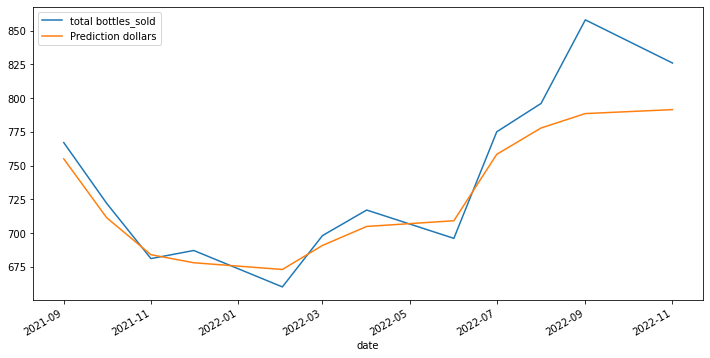

In [ ]:
# instanciation and using our class
lstm = LSTM_Prediction('/content/data.csv')
lstm.make_plot()

In [ ]:
# Save Our Figure
lstm.save_model()

In [ ]:
from keras.models import load_model

df = pd.read_csv('/content/data_new.csv' ,index_col = 'date' , parse_dates=True)
n_input = 12
n_features = 1
model = load_model('/content/LSTM_model.h5')

In [ ]:
first_data = df[(len(df)-12):]
scaler = MinMaxScaler().fit(first_data)
first_data = scaler.transform(first_data)[-n_input:]

In [ ]:
# lets now make some prediction
test_prediction = []

first_data = first_data
current_data = first_data.reshape((1 , n_input , n_features))

for i in range(12):
  # make the predection
  current_pred = model.predict(current_data)[0]

  # append prection result
  test_prediction.append(current_pred)

  # use the next data and so on
  current_data = np.append(
      current_data[: , 1: , :],
      [[current_pred]],
      axis = 1
  )

1/1 [==============================] - 0s 14ms/step


In [ ]:
data = scaler.inverse_transform(test_prediction)
data

array([[825.10176229],
       [771.66282034],
       [722.67784148],
       [723.04571879],
       [715.29743546],
       [731.98106629],
       [747.86687136],
       [762.82274222],
       [820.34569287],
       [858.75209999],
       [903.33654213],
       [907.59564114]])